In [1]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-oskeejp5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-oskeejp5
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953624 sha256=92ec5a1cdcab32621d04e896ea29e5b8c298cb81dc7eed6864cdc56b87b24cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmzwnkej/wheels/88/21/5e/57cab1c1078317022fe11d86e1596fdaa12260531220ac0c99
Successfully built glide-text2im


In [2]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [3]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [4]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

/usr/local/lib/python3.10/dist-packages/glide_text2im/download.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(path, map_location=device)


total base parameters 385030726


In [5]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [6]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [34]:
# Sampling parameters
prompt = "a dog kicking to ball"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

  0%|          | 0/100 [00:00<?, ?it/s]

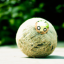

In [31]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

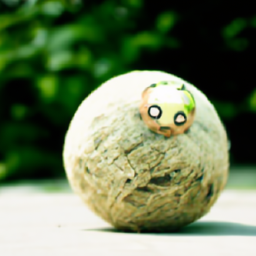

In [32]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 10.6 MB/s eta 0:00:00


In [33]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip train2017.zip
!unzip annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/000000547768.jpg  
 extracting: train2017/000000423162.jpg  
 extracting: train2017/000000224149.jpg  
 extracting: train2017/000000117841.jpg  
 extracting: train2017/000000251660.jpg  
 extracting: train2017/000000110997.jpg  
 extracting: train2017/000000424728.jpg  
 extracting: train2017/00

Seperate the COCO Dataset

In [35]:
import os
import json
import shutil
import random
from tqdm import tqdm

# --- Paths ---
coco_images_path = '/content/train2017'  # Path to COCO images
coco_annotations_path = '/content/annotations/captions_train2017.json'  # Captions annotation file

output_dir = '/content/output/'  # Directory where train/val/test folders will be saved
os.makedirs(output_dir, exist_ok=True)

# Paths for train, validation, and test splits
train_images_path = os.path.join(output_dir, 'train2017')
val_images_path = os.path.join(output_dir, 'val2017')
test_images_path = os.path.join(output_dir, 'test2017')

# Create directories for image splits
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)

# --- Load COCO Captions JSON ---
with open(coco_annotations_path, 'r') as f:
    coco_data = json.load(f)

images = coco_data['images']  # List of all images
annotations = coco_data['annotations']  # List of all annotations

# --- Shuffle and Split Data ---
random.seed(42)  # For reproducibility
random.shuffle(images)

num_images = len(images)
train_split = int(0.8 * num_images)
val_split = int(0.9 * num_images)

train_images = images[:train_split]
val_images = images[train_split:val_split]
test_images = images[val_split:]

print(f"Total images: {num_images}, Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

# --- Split Captions ---
def get_annotations_for_images(images_subset, annotations):
    image_ids = {img['id'] for img in images_subset}
    return [ann for ann in annotations if ann['image_id'] in image_ids]

train_annotations = get_annotations_for_images(train_images, annotations)
val_annotations = get_annotations_for_images(val_images, annotations)
test_annotations = get_annotations_for_images(test_images, annotations)

# --- Save JSON Files ---
def save_json(data, path):
    with open(path, 'w') as f:
        json.dump(data, f)

save_json({'images': train_images, 'annotations': train_annotations}, os.path.join(output_dir, 'captions_train2017.json'))
save_json({'images': val_images, 'annotations': val_annotations}, os.path.join(output_dir, 'captions_val2017.json'))
save_json({'images': test_images, 'annotations': test_annotations}, os.path.join(output_dir, 'captions_test2017.json'))

# --- Copy Images to Corresponding Directories ---
def copy_images(images_subset, src_folder, dest_folder):
    for img_info in tqdm(images_subset, desc=f"Copying to {dest_folder}"):
        img_filename = img_info['file_name']
        src_path = os.path.join(src_folder, img_filename)
        dest_path = os.path.join(dest_folder, img_filename)
        shutil.copy(src_path, dest_path)

copy_images(train_images, coco_images_path, train_images_path)
copy_images(val_images, coco_images_path, val_images_path)
copy_images(test_images, coco_images_path, test_images_path)

print("Data split and files copied successfully!")

Total images: 118287, Train: 94629, Val: 11829, Test: 11829


Copying to /content/output/test2017: 100%|██████████| 11829/11829 [00:27<00:00, 431.47it/s]

Data split and files copied successfully!


In [36]:
# --- Save Train Captions as a List ---
# --- Split Captions ---
# --- Shuffle and Split Data --
import random
random.seed(42)  # For reproducibility
random.shuffle(images)

num_images = len(images)
train_split = int(0.8 * num_images)
val_split = int(0.9 * num_images)

train_images = images[:train_split]
def get_annotations_for_images(images_subset, annotations):
    image_ids = {img['id'] for img in images_subset}
    return [ann for ann in annotations if ann['image_id'] in image_ids]

train_annotations = get_annotations_for_images(train_images, annotations)
train_captions_list = [ann['caption'] for ann in train_annotations]

# Save captions list to a file (optional)
captions_file_path = os.path.join(output_dir, 'train_captions_list.txt')
with open(captions_file_path, 'w') as f:
    for caption in train_captions_list:
        f.write(caption + '\n')

print(f"Total train captions: {len(train_captions_list)}")
print(f"First 5 train captions: {train_captions_list[:5]}")

Total train captions: 473390
First 5 train captions: ['A bicycle replica with a clock as the front wheel.', 'A room with blue walls and a white sink and door.', 'Blue and white color scheme in a small bathroom.', 'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.', 'A blue boat themed bathroom with a life preserver on the wall']


In [37]:
from PIL import Image
# --- Copy and Resize Images ---
def copy_and_resize_images(images_subset, src_folder, dest_folder):
    for img_info in tqdm(images_subset, desc=f"Resizing and copying to {dest_folder}"):
        img_filename = img_info['file_name']
        src_path = os.path.join(src_folder, img_filename)
        dest_path = os.path.join(dest_folder, img_filename)

        # Open and resize image
        with Image.open(src_path) as img:
            img_resized = img.resize((64, 64))  # Resize to 256x256
            img_resized.save(dest_path)

# Resize and copy images to train, val, and test directories
copy_and_resize_images(train_images, coco_images_path, train_images_path)
copy_and_resize_images(val_images, coco_images_path, val_images_path)
copy_and_resize_images(test_images, coco_images_path, test_images_path)

print("Data split, resized images, and files saved successfully!")

Resizing and copying to /content/output/train2017: 100%|██████████| 94629/94629 [10:30<00:00, 150.17it/s]
Resizing and copying to /content/output/test2017: 100%|██████████| 11829/11829 [01:11<00:00, 165.10it/s]

Data split, resized images, and files saved successfully!


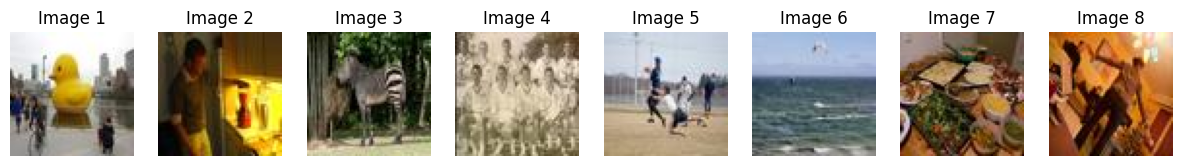

In [42]:
import matplotlib.pyplot as plt

def show_first_n_images_inline(image_folder, n=5):
    """Display the first `n` images from a folder inline using matplotlib."""
    image_files = os.listdir(image_folder)[:n]  # Get first `n` image filenames
    plt.figure(figsize=(15, 5))

    for i, img_filename in enumerate(image_files):
        img_path = os.path.join(image_folder, img_filename)
        with Image.open(img_path) as img:
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image {i + 1}")

    plt.show()

# Show the first 5 images from the training set
show_first_n_images_inline(test_images_path, n=8)

Generate Images Using Glide Model

In [ ]:
# Store the values in seperate file

In [ ]:


for i in train_captions_list[:5]:
    # Sampling parameters
    prompt = i
    batch_size = 1
    guidance_scale = 3.0

    # Tune this parameter to control the sharpness of 256x256 images.
    # A value of 1.0 is sharper, but sometimes results in grainy artifacts.
    upsample_temp = 0.997
    ##############################
    # Sample from the base model #
    ##############################

    # Create the text tokens to feed to the model.
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )

    # Create the classifier-free guidance tokens (empty)
    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
        [], options['text_ctx']
    )

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Create a classifier-free guidance sampling function
    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = th.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = th.cat([half_eps, half_eps], dim=0)
        return th.cat([eps, rest], dim=1)

    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model.del_cache()


    ##############################
    # Upsample the 64x64 samples #
    ##############################

    tokens = model_up.tokenizer.encode(prompt)
    tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
        tokens, options_up['text_ctx']
    )

    # Create the model conditioning dict.
    model_kwargs = dict(
        # Low-res image to upsample.
        low_res=((samples+1)*127.5).round()/127.5 - 1,

        # Text tokens
        tokens=th.tensor(
            [tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Sample from the base model.
    model_up.del_cache()
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
    up_samples = diffusion_up.ddim_sample_loop(
        model_up,
        up_shape,
        noise=th.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model_up.del_cache()
    print(i)
    # Show the output
    show_images(up_samples)

  0%|          | 0/100 [00:00<?, ?it/s]

CLIP Score

In [ ]:
import torch
import clip
from PIL import Image

# Load the CLIP model and preprocess function
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to compute CLIP score
def compute_clip_score(image_path, text_prompt):
    # Load and preprocess the image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Encode the image and text
    text = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

    # Normalize features to unit vectors
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity (CLIP score)
    similarity = (image_features @ text_features.T).item()

    return similarity

# Example Usage
image_path = "/content/Unknown-2.png"  # Path to your image file
text_prompt = "a photograph of an astronaut riding a horse"  # Your text description
clip_score = compute_clip_score(image_path, text_prompt)
print(f"CLIP Score: {clip_score:.4f}")

FID

In [ ]:
!pip install torch torchvision scipy numpy pillow tqdm
!pip install git+https://github.com/mseitzer/pytorch-fid.git

In [ ]:
import torch
from pytorch_fid import fid_score

# Function to compute FID for text-to-image generation
def compute_text_to_image_fid(real_images_dir, generated_images_dir, batch_size=16):
    """
    real_images_dir: Path to directory containing real images corresponding to text prompts.
    generated_images_dir: Path to directory containing images generated from text prompts.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Compute FID between real and generated image sets
    fid_value = fid_score.calculate_fid_given_paths([real_images_dir, generated_images_dir],
    batch_size=batch_size,
    device=device,
    dims=2048)
    print(f"FID Score (Text-to-Image): {fid_value:.4f}")
    return fid_value

# Example Usage
real_images_path = "/content/output/test2017"  # Real images (e.g., from MS COCO)
generated_images_path = "/content/real"  # Model-generated images
fid_score_value = compute_text_to_image_fid(real_images_path, generated_images_path,64)

Diveristy Score

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
from itertools import combinations

# Load CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to compute Diversity Score
def compute_diversity_score(image_paths):
    """
    Compute diversity score (DS) for a set of generated images.

    Args:
    - image_paths: List of paths to generated images.

    Returns:
    - diversity_score: The average pairwise cosine distance between image embeddings.
    """
    image_embeddings = []

    # Extract embeddings for each image
    for img_path in image_paths:
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_embedding = model.encode_image(image)
            image_embedding /= image_embedding.norm(dim=-1, keepdim=True)  # Normalize embeddings
            image_embeddings.append(image_embedding.cpu().numpy().squeeze())

    # Convert list to numpy array
    image_embeddings = np.array(image_embeddings)

    # Compute pairwise cosine distances
    pairwise_distances = []
    for (img1, img2) in combinations(image_embeddings, 2):
        cosine_similarity = np.dot(img1, img2) / (np.linalg.norm(img1) * np.linalg.norm(img2))
        distance = 1 - cosine_similarity  # Cosine distance
        pairwise_distances.append(distance)

    # Average pairwise distance as diversity score
    diversity_score = np.mean(pairwise_distances)
    print(f"Diversity Score (DS): {diversity_score:.4f}")
    return diversity_score

# Example Usage
generated_image_paths = ""

compute_diversity_score(generated_image_paths)

Insecption Score (IS)